In [1]:
import pickle
import numpy as np
import pandas as pd
import pydotplus as pp
import matplotlib.pyplot as plt

from IPython.display import Image

from scipy.stats import gaussian_kde
from scipy.ndimage.filters import gaussian_filter1d

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.model_selection import train_test_split

import warnings, matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

___

In [2]:
df = pd.read_csv('Data/train.csv')
X  = df.drop('% achievements gotten', axis=1)
y  = df['% achievements gotten']

runs, criterion, max_depth, min_samples_split = 1000, 'friedman_mse', 5, 68
min_samples_leaf, max_leaf_nodes, min_weight_fraction_leaf = 57, 72, .052

plt.rc('axes', axisbelow=True)

In [3]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

criterion_mae, criterion_mse, criterion_rmse = [], [], []
for c in ['mse', 'friedman_mse', 'mae']:
    dtr.set_params(criterion=c)
    imae, imse, irmse = ([], [], [])
    
    for _ in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        dtr.fit(X_train, y_train)

        y_pred = dtr.predict(X_test)

        imae.append(mean_absolute_error(y_test, y_pred))
        imse.append(mean_squared_error(y_test, y_pred))
        irmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    criterion_mae.append(np.mean(imae))
    criterion_mse.append(np.mean(imse))
    criterion_rmse.append(np.mean(irmse))

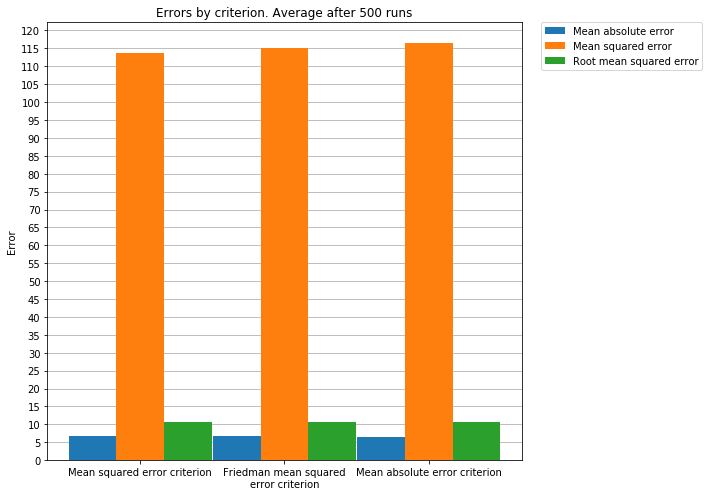

In [4]:
plt.figure(figsize=(10,7))
plt.title('Errors by criterion. Average after ' + str(runs) + ' runs')
plt.ylabel('Error')

index, width = np.arange(3), .33
rects1 = plt.bar(index, criterion_mae, width, label='Mean absolute error')
rects2 = plt.bar(index + width, criterion_mse, width, label='Mean squared error')
rects3 = plt.bar(index + width * 2, criterion_rmse, width, label='Root mean squared error')


plt.xticks(index + width, ('Mean squared error criterion', 'Friedman mean squared\nerror criterion',
                           'Mean absolute error criterion'))
plt.yticks(range(0,121,5))
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

<b> Optimal criterion: Friedman mean squared error (friedman_mse) </b>

___

In [5]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

split_scores = []
for k in range(2,151):
    dtr.set_params(min_samples_split=k)
    scores = []
    
    for _ in range(int(runs/2)):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        dtr.fit(X_train, y_train)

        y_pred = dtr.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    split_scores.append(np.mean(scores))

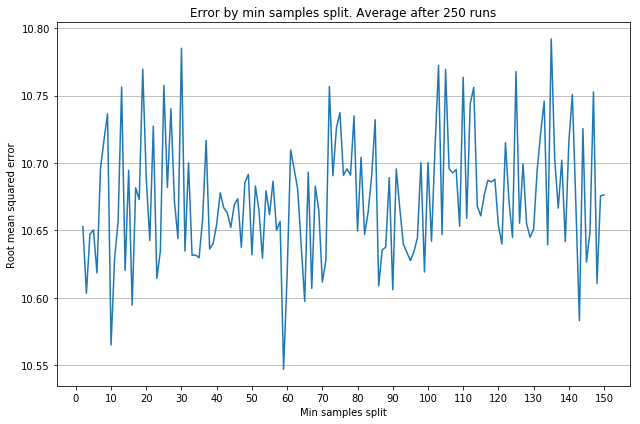

In [6]:
plt.figure(figsize=(9,6))
plt.title('Error by min samples split. Average after ' + str(int(runs/2)) + ' runs')
plt.xlabel('Min samples split')
plt.ylabel('Root mean squared error')

plt.plot(range(2,151), split_scores)
plt.xticks(range(0,151,10))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

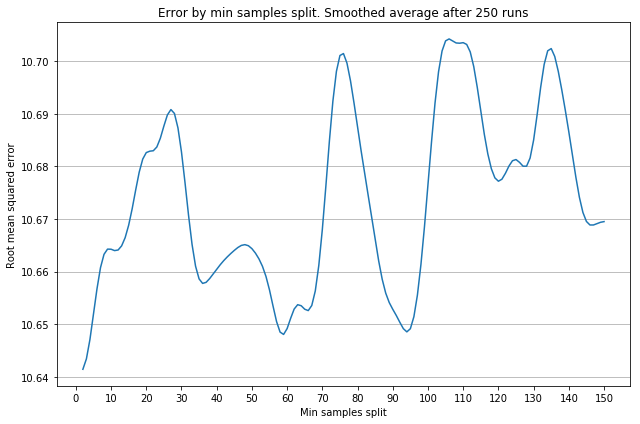

In [7]:
plt.figure(figsize=(9,6))
plt.title('Error by min samples split. Smoothed average after ' + str(int(runs/2)) + ' runs')
plt.xlabel('Min samples split')
plt.ylabel('Root mean squared error')

smooth_split_scores = gaussian_filter1d(split_scores, sigma=3)

plt.plot(range(2,151), smooth_split_scores)
plt.xticks(range(0,151,10))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

<b> Optimal min samples split: 68 </b>

___

In [8]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

depth_scores = []
for k in range(1,51):
    dtr.set_params(max_depth=k)
    scores = []
    
    for _ in range(runs * 2):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        dtr.fit(X_train, y_train)
 
        y_pred = dtr.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    depth_scores.append(np.mean(scores))

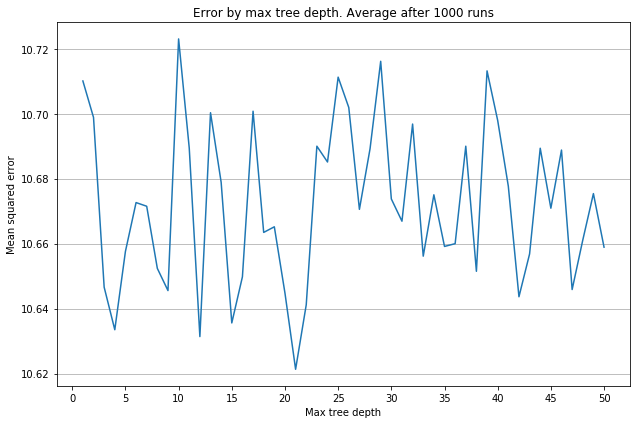

In [9]:
plt.figure(figsize=(9,6))
plt.title('Error by max tree depth. Average after ' + str(runs * 2) + ' runs')
plt.xlabel('Max tree depth')
plt.ylabel('Mean squared error')

plt.plot(range(1,51), depth_scores)
plt.xticks(range(0,51,5))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

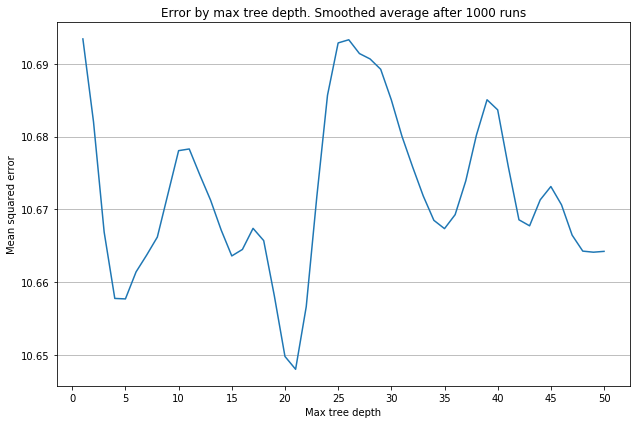

In [10]:
plt.figure(figsize=(9,6))
plt.title('Error by max tree depth. Smoothed average after ' + str(runs * 2) + ' runs')
plt.xlabel('Max tree depth')
plt.ylabel('Mean squared error')

smooth_depth_scores = gaussian_filter1d(depth_scores, sigma=1.5)

plt.plot(range(1,51), smooth_depth_scores)
plt.xticks(range(0,51,5))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

<b> Optimal tree depth: 5 </b>

___

In [11]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

leaf_scores = []
for k in range(1,101):
    dtr.set_params(min_samples_leaf=k)
    scores = []
    
    for _ in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        dtr.fit(X_train, y_train)
 
        y_pred = dtr.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    leaf_scores.append(np.mean(scores))

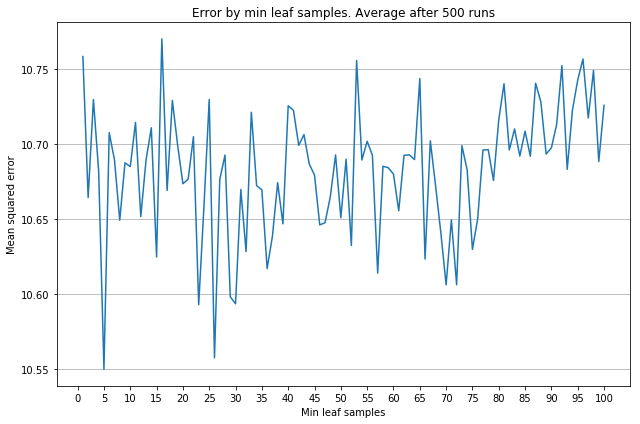

In [12]:
plt.figure(figsize=(9,6))
plt.title('Error by min leaf samples. Average after ' + str(runs) + ' runs')
plt.xlabel('Min leaf samples')
plt.ylabel('Mean squared error')

plt.plot(range(1,101), leaf_scores)
plt.xticks(range(0,101,5))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

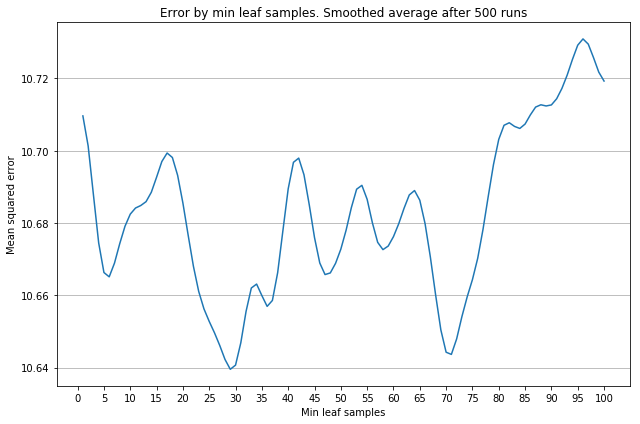

In [13]:
plt.figure(figsize=(9,6))
plt.title('Error by min leaf samples. Smoothed average after ' + str(runs) + ' runs')
plt.xlabel('Min leaf samples')
plt.ylabel('Mean squared error')

smooth_leaf_scores = gaussian_filter1d(leaf_scores, sigma=2)

plt.plot(range(1,101), smooth_leaf_scores)
plt.xticks(range(0,101,5))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

<b> Optimal min samples leaf: 57 </b>

___

In [14]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

weight_scores = []
for k in np.arange(0,.51,.05):
    dtr.set_params(min_weight_fraction_leaf=k)
    scores = []
    
    for _ in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        dtr.fit(X_train, y_train)
 
        y_pred = dtr.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    weight_scores.append(np.mean(scores))

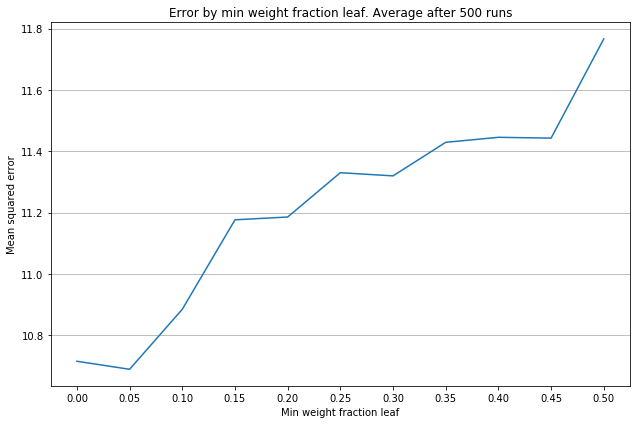

In [15]:
plt.figure(figsize=(9,6))
plt.title('Error by min weight fraction leaf. Average after ' + str(runs) + ' runs')
plt.xlabel('Min weight fraction leaf')
plt.ylabel('Mean squared error')

plt.plot(np.arange(0,.51,.05), weight_scores)
plt.xticks(np.arange(0,.51,.05))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

In [16]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

weight_scores2 = []
for k in np.arange(.045,.056,.0005):
    dtr.set_params(min_weight_fraction_leaf=k)
    scores = []
    
    for _ in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        dtr.fit(X_train, y_train)
 
        y_pred = dtr.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    weight_scores2.append(np.mean(scores))

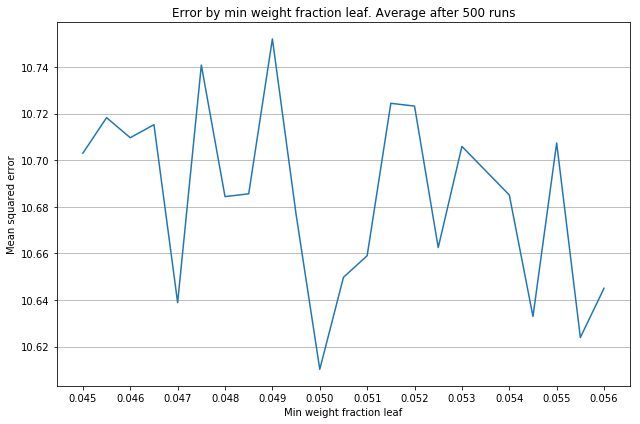

In [17]:
plt.figure(figsize=(9,6))
plt.title('Error by min weight fraction leaf. Average after ' + str(runs) + ' runs')
plt.xlabel('Min weight fraction leaf')
plt.ylabel('Mean squared error')

plt.plot(np.arange(.045,.056,.0005), weight_scores2)
plt.xticks(np.arange(.045,.056,.001))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

<b> Optimal min weight fraction leaf: .052 </b>

___

In [18]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

max_leaf_scores = []
for k in range(2,253,5):
    scores = []
    dtr.set_params(max_leaf_nodes=k)
    
    for _ in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        dtr.fit(X_train, y_train)
 
        y_pred = dtr.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    max_leaf_scores.append(np.mean(scores))

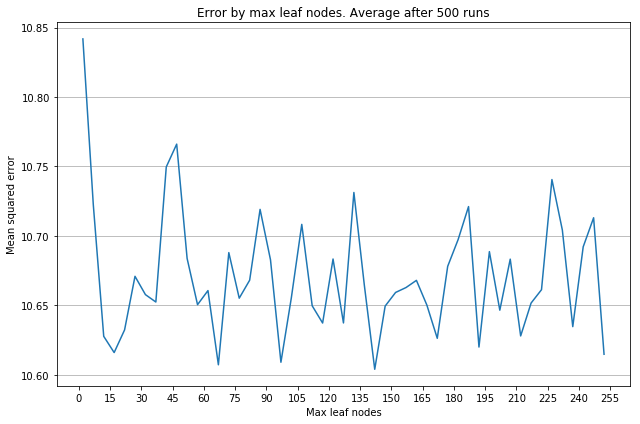

In [19]:
plt.figure(figsize=(9,6))
plt.title('Error by max leaf nodes. Average after ' + str(runs) + ' runs')
plt.xlabel('Max leaf nodes')
plt.ylabel('Mean squared error')

plt.plot(range(2,253,5), max_leaf_scores)
plt.xticks(range(0,256,15))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

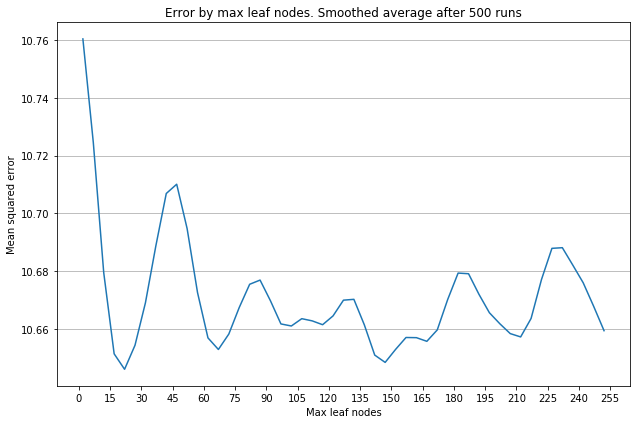

In [20]:
plt.figure(figsize=(9,6))
plt.title('Error by max leaf nodes. Smoothed average after ' + str(runs) + ' runs')
plt.xlabel('Max leaf nodes')
plt.ylabel('Mean squared error')

smooth_max_leaf_scores = gaussian_filter1d(max_leaf_scores, sigma=1.5)

plt.plot(range(2,253,5), smooth_max_leaf_scores)
plt.xticks(range(0,256,15))
plt.axes().yaxis.grid()
plt.tight_layout()
plt.show()

<b> Optimal max leaf nodes: 72 </b>

___

In [12]:
with open('Data/tree.pkl', 'rb') as f:  
    dtr = pickle.load(f)

dtr.set_params(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split,
               min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes,
               min_weight_fraction_leaf=min_weight_fraction_leaf)

avg_mae, avg_mse, avg_rmse = [], [], []
for _ in range(runs * 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    dtr.fit(X_train, y_train)
    
    y_pred = dtr.predict(X_test)
    
    avg_mae.append(mean_absolute_error(y_test, y_pred))
    avg_mse.append(mean_squared_error(y_test, y_pred))
    avg_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

with open('Data/tree.pkl', 'wb') as f:
    pickle.dump(dtr, f)

print('Mean absolute error:'.rjust(24), np.mean(avg_mae))
print('Mean squared error:'.rjust(24), np.mean(avg_mse))
print('Root mean squared error:', np.mean(avg_rmse))

    Mean absolute error: 6.857908493394794
     Mean squared error: 114.62364281720824
Root mean squared error: 10.675436899175175


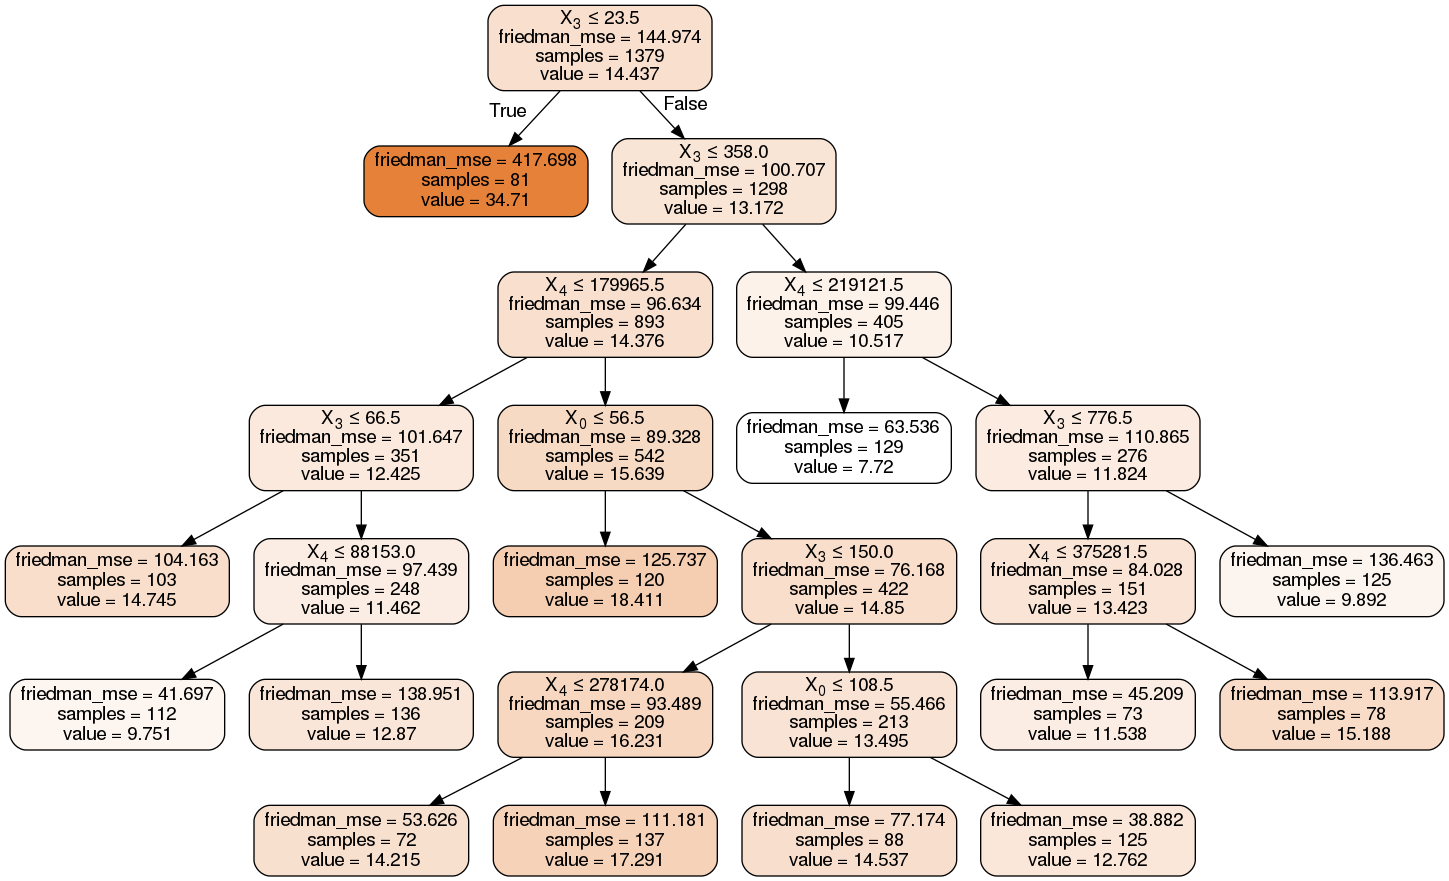

In [13]:
dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pp.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Figures/tree.png')
Image(graph.create_png())

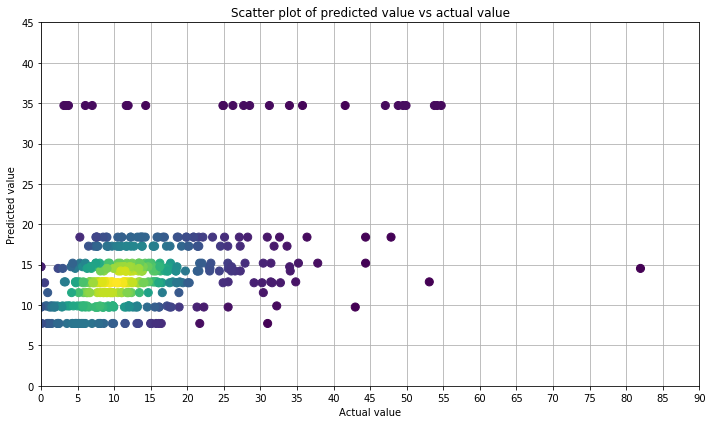

In [14]:
xy = np.vstack([y_test,y_pred])
z  = gaussian_kde(xy)(xy)

plt.figure(figsize=(10,6))
plt.title('Scatter plot of predicted value vs actual value')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

plt.scatter(y_test, y_pred, c=z, s=65)
plt.xticks(range(0,101,5))
plt.yticks(range(0,61,5))
plt.xlim(0,90)
plt.ylim(0,45)
plt.grid()
plt.tight_layout()

plt.savefig('Figures/predictions.png')
plt.show()